In [51]:
import pandas as pd 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [53]:
folder = "/media/riannek/minimax/gleis/speed_run24"
df = pd.read_csv(os.path.join(folder, 'speedlog.csv'))
df['file'] = df['file'].fillna("")
df['file'] = df['file'].apply(lambda x: os.path.basename(x))
df['what'] = df['what'].replace({'voxelfilter': 'Voxelfilter', 'Growing lines': 'GrowingLines', 'Central points': 'zentrale Punkte', 'read': 'Lesen'})
df.head()


,what,file,time,points
0,Lesen,4475525_5341275.copc.laz,1.030543,1298026
1,Voxelfilter,4475525_5341275.copc.laz,4.606606,145607
2,Lesen,4475625_5341350.copc.laz,0.248658,268017
3,Voxelfilter,4475625_5341350.copc.laz,1.044499,28071
4,Lesen,4478600_5350025.copc.laz,0.212417,192602


Voxelfilter ist hier ohne read:

In [26]:
grouped = df.groupby('what')['time'].sum()  / 60
grouped  

what
GrowingLines           16.215731
Lesen                  47.557486
Points with margin      0.000000
Seed points             0.000000
Voxelfilter           139.657766
zentrale Punkte        90.838731
Name: time, dtype: float64

In [29]:
grouped['Voxelfilter'] = grouped['Voxelfilter'] + grouped['Lesen'] 
read = grouped['Lesen']
grouped = grouped.drop('Lesen')
grouped = grouped[grouped > 0]

In [35]:
grouped  

what
GrowingLines        16.215731
Voxelfilter        187.215252
zentrale Punkte     90.838731
Name: time, dtype: float64

In [41]:
grouped * 100 / grouped.sum()

what
Voxelfilter        63.620292
zentrale Punkte    30.869208
GrowingLines        5.510499
Name: time, dtype: float64

In [42]:
read * 100 / grouped.sum()

np.float64(16.161189492864906)

In [46]:
read * 100 / grouped['Voxelfilter']

np.float64(25.402570297747083)

In [45]:
grouped.sum() // 60, grouped.sum() % 60

(np.float64(4.0), np.float64(54.26971327066423))

In [36]:
custom_order = ['Voxelfilter', 'zentrale Punkte' ,'GrowingLines']
grouped = grouped.loc[custom_order]

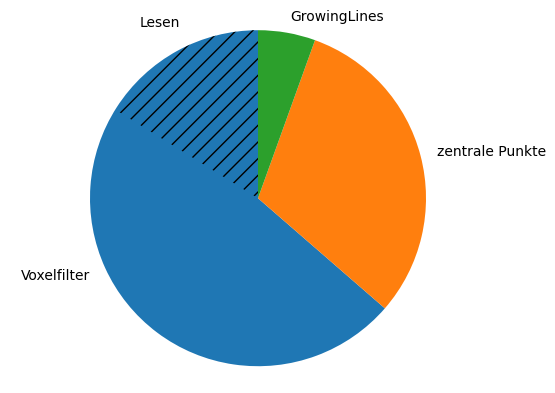

In [40]:
import matplotlib.pyplot as plt

# Prepare data
labels = grouped.index
sizes = grouped.values

# Pie chart
fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, labels=labels, startangle=90)

# Find index of the combined category
combined_index = list(labels).index('Voxelfilter')

# Overlay the "hatched" part (e.g., 'bar') manually
# Calculate angle for the segment
angle = 360 * read / grouped.sum()

# Determine where the wedge starts
startangle = 90  # if same as above
angle_offset = sum(sizes[:combined_index]) / sizes.sum() * 360

# Draw a hatched wedge manually
from matplotlib.patches import Wedge

theta1=startangle + angle_offset
theta2=theta1 + angle
theta_mid = (theta1 + theta2) / 2

hatch_wedge = Wedge(center=(0, 0),
                    r=1, #0.95,  # slightly smaller
                    theta1=theta1,
                    theta2=theta2,
                    facecolor='none',
                    hatch='//',
                    edgecolor='black',
                    linewidth=0)

ax.add_patch(hatch_wedge)

# Convert polar to cartesian for label position
r = 1.2  # radius slightly outside the wedge
x = r * np.cos(np.deg2rad(theta_mid))
y = r * np.sin(np.deg2rad(theta_mid))

# Add the label manually
ax.text(x, y, 'Lesen', ha='center', va='center')

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gcf().savefig('speed_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()


In [54]:
linelayer = gpd.read_file(os.path.join(folder, 'temp.gpkg'), layer='centerlines')
linelayer.head()

,used,geometry
0,0,"LINESTRING Z (4474820.37 5340468.796 503.114, ..."
1,0,"LINESTRING Z (4476157.809 5342334.019 485.047,..."
2,1,"LINESTRING Z (4474825.226 5340468.253 503.113,..."
3,1,"LINESTRING Z (4476144.902 5342268.597 485.371,..."
4,1,"LINESTRING Z (4476474.53 5343841.848 486.476, ..."


In [56]:
linelayer['num_points'] = linelayer.geometry.apply(lambda geom: len(geom.coords))
linelayer.head()

,used,geometry,num_points
0,0,"LINESTRING Z (4474820.37 5340468.796 503.114, ...",2676
1,0,"LINESTRING Z (4476157.809 5342334.019 485.047,...",825
2,1,"LINESTRING Z (4474825.226 5340468.253 503.113,...",2594
3,1,"LINESTRING Z (4476144.902 5342268.597 485.371,...",1852
4,1,"LINESTRING Z (4476474.53 5343841.848 486.476, ...",239


In [57]:
linelayer['num_points'].describe()

count      153.000000
mean       503.862745
std       1286.722254
min         10.000000
25%         39.000000
50%        110.000000
75%        344.000000
max      10759.000000
Name: num_points, dtype: float64

In [58]:
linepointsum = linelayer['num_points'].sum()
linepointsum  

np.int64(77091)

In [66]:
df['what2'] = df['what'].replace({'Lesen': 'Punktwolke', 'Seed points': 'Saatpunkte', 'GrowingLines': 'Stützpunkte Linestrings'})
punktzahl = df.groupby('what2')['points'].sum()
punktzahl 

what2
Points with margin          264930110
Punktwolke                 3715574762
Saatpunkte                     698747
Stützpunkte Linestrings             0
Voxelfilter                 199271321
zentrale Punkte                346379
Name: points, dtype: int64

In [67]:
punktzahl['Stützpunkte Linestrings'] = linepointsum
punktzahl.drop('Points with margin', inplace=True)

custom_order = ['Punktwolke', 'Voxelfilter', 'Saatpunkte', 'zentrale Punkte', 'Stützpunkte Linestrings']
punktzahl = punktzahl.loc[custom_order] 
punktzahl 

what2
Punktwolke                 3715574762
Voxelfilter                 199271321
Saatpunkte                     698747
zentrale Punkte                346379
Stützpunkte Linestrings         77091
Name: points, dtype: int64